In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import cv2
import numpy as np
from tqdm import tqdm
from collections import OrderedDict
from torch.optim.lr_scheduler import StepLR


In [2]:
train = datasets.MNIST("../data/", train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("../data/", train=False, download=True, transform = transforms.Compose([transforms.ToTensor()]))

In [3]:
IM_SIZE = 28 * 28
IM_SHAPE = (28, 28)
CPU_training = False
BATCH = 100
use_cuda =  torch.cuda.is_available() and not CPU_training
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trainset = torch.utils.data.DataLoader(train, batch_size=BATCH, shuffle=True, **kwargs)
testset = torch.utils.data.DataLoader(test, batch_size=BATCH, shuffle=True, **kwargs)

In [4]:
PCA_dim = 2
PCA_2d = nn.Sequential(OrderedDict([
            ('fc1_en', nn.Linear(IM_SIZE, PCA_dim)),
            ('relu1', nn.PReLU()),
            ('fc1_de', nn.Linear(PCA_dim, IM_SIZE)),
            ('sigmoid1', nn.Softmax(dim=1))    
         ])).to(device)


In [5]:
# nn.PReLU()
auto_dim = 2
auto_2d = nn.Sequential(OrderedDict([
            ('fc1_en', nn.Linear(IM_SIZE, 64)),
            ('relu1', nn.PReLU()),
            ('fc2_en', nn.Linear(64, 16)),
            ('relu2', nn.PReLU()),
            ('fc3_en', nn.Linear(16, auto_dim)),
            ('relu3', nn.PReLU()),
            ('fc1_de', nn.Linear(auto_dim, 16)),
            ('relu4', nn.PReLU()),
            ('fc2_de', nn.Linear(16, 64)),
            ('relu5', nn.PReLU()),
            ('fc3_de', nn.Linear(64, IM_SIZE)),
            ('sigmoid1', nn.Softmax(dim=1))    
          ])).to(device)

In [6]:
"""
SOURCE: https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6
"""

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

PCA_2d.fc1_en.register_forward_hook(get_activation('fc1_en'))
PCA_2d.relu1.register_forward_hook(get_activation('relu1'))

auto_2d.relu3.register_forward_hook(get_activation('relu3'))

In [7]:
net = PCA_2d.train()

optimizer = optim.Adadelta(net.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
EPOCHS = 5

for epoch in range(EPOCHS):
    for X, _ in tqdm(trainset):
        X = X.view(-1, IM_SIZE).to(device)
        net.zero_grad()
        output = net(X)
        loss = F.binary_cross_entropy(output, X)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(epoch, loss)

  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

0 tensor(0.7722, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

1 tensor(0.8370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

2 tensor(0.8198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

3 tensor(0.8501, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:05<00:00, 102.19it/s]

4 tensor(0.8165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100it [00:01, 55.97it/s]


tensor(889353.5625, device='cuda:0')


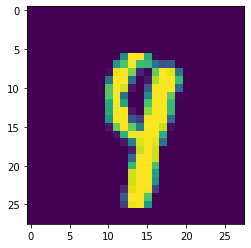

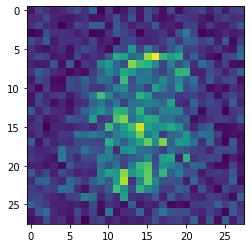

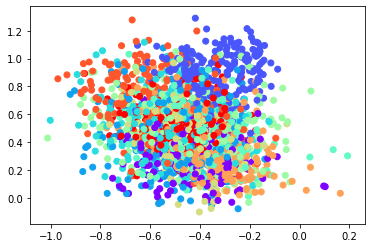

In [9]:
net = PCA_2d.eval()

comp_data = np.empty((10000, PCA_dim))
comp_label = np.empty((10000,))
loss = 0
with torch.no_grad():
    for i, (X, y) in tqdm(enumerate(testset)):
        X = X.view(-1, IM_SIZE).to(device)
        output = net(X)
        comp_data[BATCH * i: BATCH * (i + 1)] = activation['relu1'].cpu()
        comp_label[BATCH * i: BATCH * (i + 1)] = y

        loss += F.mse_loss(output, X, reduction='sum')

print(loss)
if use_cuda:
    X = X.cpu()
    output = output.cpu()
plt.imshow(X[0].view(IM_SHAPE))
plt.show()
plt.imshow(output[0].view(IM_SHAPE))
plt.show()

plt.scatter(comp_data[0:-1:5,0], comp_data[0:-1:5,1], c=comp_label[0:-1:5], cmap=plt.cm.rainbow)
plt.show()


In [10]:
net = auto_2d.train()

optimizer = optim.Adadelta(net.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
EPOCHS = 5

for epoch in range(EPOCHS):
    for X, _ in tqdm(trainset):
        X = X.view(-1, IM_SIZE).to(device)
        net.zero_grad()
        output = net(X)
        loss = F.binary_cross_entropy(output, X)
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(epoch, loss)

  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

0 tensor(0.7828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

1 tensor(0.7595, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

2 tensor(0.7503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  0%|                                                                                          | 0/600 [00:00<?, ?it/s]

3 tensor(0.7570, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:09<00:00, 64.64it/s]

4 tensor(0.7765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


100it [00:01, 56.63it/s]

tensor(885536.2500, device='cuda:0')


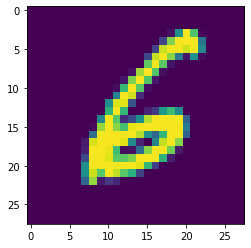

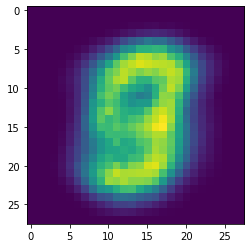

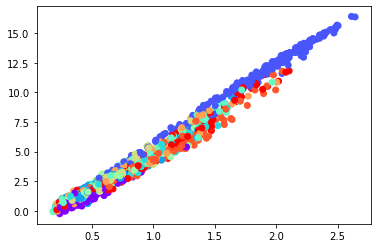

In [11]:
net = auto_2d.eval()

comp_data = np.empty((10000, auto_dim))
comp_label = np.empty((10000,))
loss = 0
with torch.no_grad():
    for i, (X, y) in tqdm(enumerate(testset)):
        X = X.view(-1, IM_SIZE).to(device)
        output = net(X)
        comp_data[BATCH * i: BATCH * (i + 1)] = activation['relu3'].cpu()
        comp_label[BATCH * i: BATCH * (i + 1)] = y

        loss += F.mse_loss(output, X, reduction='sum')

print(loss)
if use_cuda:
    X = X.cpu()
    output = output.cpu()
plt.imshow(X[0].view(IM_SHAPE))
plt.show()
plt.imshow(output[0].view(IM_SHAPE))
plt.show()

plt.scatter(comp_data[0:-1:5,0], comp_data[0:-1:5,1], c=comp_label[0:-1:5], cmap=plt.cm.rainbow)
plt.show()


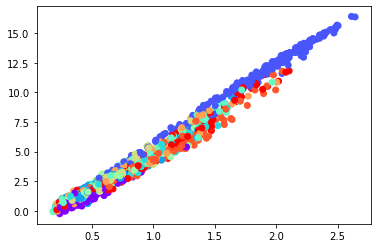

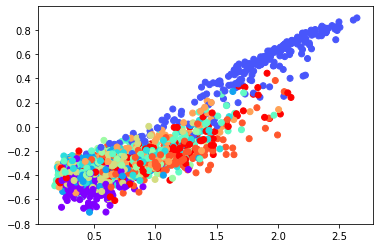

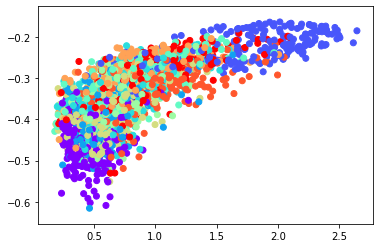

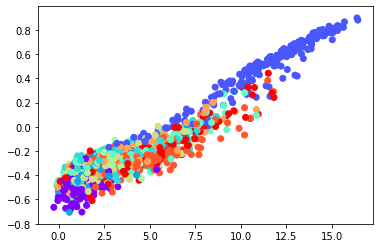

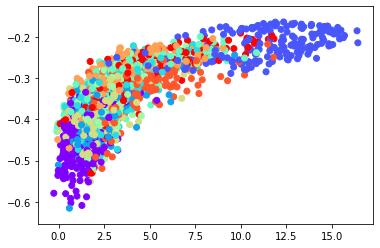

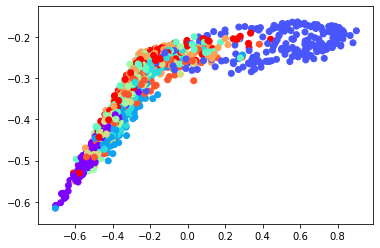

In [13]:

# plt.scatter(comp_data[0:-1:5,0], comp_data[0:-1:5,1], c=comp_label[0:-1:5], cmap=plt.cm.rainbow)
# plt.show()
# plt.scatter(comp_data[0:-1:5,0], comp_data[0:-1:5,2], c=comp_label[0:-1:5], cmap=plt.cm.rainbow)
# plt.show()
# plt.scatter(comp_data[0:-1:5,0], comp_data[0:-1:5,3], c=comp_label[0:-1:5], cmap=plt.cm.rainbow)
# plt.show()
# plt.scatter(comp_data[0:-1:5,1], comp_data[0:-1:5,2], c=comp_label[0:-1:5], cmap=plt.cm.rainbow)
# plt.show()
# plt.scatter(comp_data[0:-1:5,1], comp_data[0:-1:5,3], c=comp_label[0:-1:5], cmap=plt.cm.rainbow)
# plt.show()
# plt.scatter(comp_data[0:-1:5,2], comp_data[0:-1:5,3], c=comp_label[0:-1:5], cmap=plt.cm.rainbow)
# plt.show()